# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?
 
*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install subword_nmt

In [3]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('/content/drive/MyDrive/data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:11<00:00, 723.02it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [4]:
import numpy as np

In [5]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [6]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [7]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное! 
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
seed_everything(42)

In [11]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        
        return self.decode(initial_state, out)

    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последний на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)

        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]
        prev_gru0_tokens = prev_tokens
        
        x = self.emb_out(prev_gru0_tokens)
        new_dec_state = self.dec0(x, prev_state[0])

        output_logits = self.logits(new_dec_state)
        
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)

        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)

        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [12]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [13]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
third asts section bremen reland kastrup above posed posed alexand@@ bakery arg@@ itality freedom bri@@ beijing newspaper stainless collection pensiunea trevi trevi lig@@ pur@@ seaside
third asts section bremen reland kastrup above posed posed alexand@@ bakery arg@@ itality freedom bri@@ beijing newspaper stainless collection pensiunea trevi trevi lig@@ pur@@ seaside
third asts section bremen reland kastrup above posed posed alexand@@ bakery arg@@ itality freedom bri@@ beijing newspaper stainless collection pensiunea trevi trevi lig@@ pur@@ seaside


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [14]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токенов на всех шагах
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1) # [batch_size, out_len, num_tokens]
   
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True  
    return -logp_out[mask].mean()# тут должен получиться скаляр!

In [15]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5479, device='cuda:0', grad_fn=<NegBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [16]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [17]:
compute_bleu(model, dev_inp, dev_out)

0.0014860003860051633

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [18]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32
epochs = 15

In [19]:
for epoch in range(epochs):

    model.train()

    train_loss_epoch = 0
    test_loss_epoch = 0

    for i in range(0, len(train_inp), batch_size):

        dummy_inp_t_tokens = inp_voc.to_matrix(train_inp[i:i+batch_size]).to(device)
        dummy_out_t_tokens = out_voc.to_matrix(train_out[i:i+batch_size]).to(device)

        opt.zero_grad()

        loss = loss_function(model, dummy_inp_t_tokens, dummy_out_t_tokens)

        loss.backward()
        opt.step()

        train_loss_epoch += loss.item()

    with torch.no_grad():
        
        model.eval()

        bleu = compute_bleu(model, dev_inp, dev_out)

        for i in range(0, len(dev_inp), batch_size):
            dummy_inp_d_tokens = inp_voc.to_matrix(dev_inp[i:i+batch_size]).to(device)
            dummy_out_d_tokens = out_voc.to_matrix(dev_out[i:i+batch_size]).to(device)

            loss = loss_function(model, dummy_inp_d_tokens, dummy_out_d_tokens)

            test_loss_epoch += loss.item()

    print(f'Epoch {epoch+1}')
    print(f'train_loss: {train_loss_epoch / len(train_inp)}, test_loss: {test_loss_epoch / len(dev_inp)}, test_bleu: {bleu}')
    print('-----------------------------------------------------------------------------------------------')
    
    metrics['train_loss'].append(train_loss_epoch / len(train_inp))
    metrics['dev_bleu'].append(bleu)

Epoch 1
train_loss: 0.1252665870385115, test_loss: 0.10390816068649292, test_bleu: 8.239405924108672
-----------------------------------------------------------------------------------------------
Epoch 2
train_loss: 0.09625247757915882, test_loss: 0.09427293046315512, test_bleu: 10.013998087589126
-----------------------------------------------------------------------------------------------
Epoch 3
train_loss: 0.08723663362055971, test_loss: 0.08977476414044698, test_bleu: 12.246843346747765
-----------------------------------------------------------------------------------------------
Epoch 4
train_loss: 0.08145729054471502, test_loss: 0.08722387997309367, test_bleu: 13.799364263583627
-----------------------------------------------------------------------------------------------
Epoch 5
train_loss: 0.07721977079577381, test_loss: 0.08584961473941803, test_bleu: 14.959072198898907
-----------------------------------------------------------------------------------------------
Epoch 6

In [20]:
print(f'Final BLEU seq2seq: {compute_bleu(model, dev_inp, dev_out)}')

assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 15, "Ты можешь больше! попробуй еще раз)"

Final BLEU seq2seq: 16.344594025371077


In [21]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests can use the shared kitchen facilities and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental is available , and free parking is available on site .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
latina is 26 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
featuring a garden with a terrace and a terrace , villa villa la is a villa with a terrace , and a terrace is located in the garden .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
red square in the heart of rome is a 5 - minute walk from the old town square .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with a shower and towels .



## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [22]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        self.lin1 = nn.Linear(enc_size, hid_size)
        self.lin2 = nn.Linear(dec_size, hid_size)
        self.lin3 = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """
        batch_size, ninp, enc_size = enc.shape

        dec_output = self.lin2(dec)
        dec_output = dec_output.reshape(-1, 1, self.hid_size)
        enc_output = self.lin1(enc)

        energy = torch.tanh(enc_output + dec_output)
        energy = self.lin3(energy)

        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        energy[torch.where(inp_mask == False)] = -1e9

        # Примените softmax
        probs = self.softmax(energy.reshape(batch_size, ninp))

        # Подсчитайте выход attention используя enc состояния и вероятностями
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(axis=1)

        return attn, probs

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [23]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        super().__init__(inp_voc, out_voc, emb_size, hid_size)

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size 
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """
        
        input_emb = self.emb_inp(inp)

        # делаем encode
        enc_seq, _ = self.enc0(input_emb)

        [dec_start] = super().encode(inp, **flags)    
        
        enc_mask = self.out_voc.compute_mask(inp)
        
        # apply attention layer from initial decoder hidden state
        # применяем attention слой для скрытых состояний
        first_attn_probas = self.attention(enc_seq, dec_start, enc_mask)[1]
        
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [dec_start, enc_seq, enc_mask, first_attn_probas]

        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """
        
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_prob = self.attention(enc_seq, prev_gru0_state, enc_mask)
        
        x = self.emb_out(prev_tokens)
        
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)
        
        new_dec_state = [x, enc_seq, enc_mask, attn_prob]
        output_logits = self.logits(x)

        return [new_dec_state, output_logits]

### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

In [24]:
metrics_attention = {'train_loss': [], 'dev_bleu': [] }

model_attention = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model_attention.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=1, factor=0.7)
batch_size = 32
epochs = 20

In [25]:
for epoch in range(epochs):

    model_attention.train()

    train_loss_epoch = 0
    test_loss_epoch = 0

    for i in range(0, len(train_inp), batch_size):

        dummy_inp_t_tokens = inp_voc.to_matrix(train_inp[i:i+batch_size]).to(device)
        dummy_out_t_tokens = out_voc.to_matrix(train_out[i:i+batch_size]).to(device)

        opt.zero_grad()

        loss = loss_function(model_attention, dummy_inp_t_tokens, dummy_out_t_tokens)

        loss.backward()
        opt.step()

        train_loss_epoch += loss.item()

    with torch.no_grad():
        
        model_attention.eval()

        bleu = compute_bleu(model_attention, dev_inp, dev_out)

        for i in range(0, len(dev_inp), batch_size):
            dummy_inp_d_tokens = inp_voc.to_matrix(dev_inp[i:i+batch_size]).to(device)
            dummy_out_d_tokens = out_voc.to_matrix(dev_out[i:i+batch_size]).to(device)

            loss = loss_function(model_attention, dummy_inp_d_tokens, dummy_out_d_tokens)

            test_loss_epoch += loss.item()

    scheduler.step(test_loss_epoch / len(dev_inp))

    curr_lr = opt.param_groups[0]['lr']

    print(f'Epoch {epoch+1}')
    print(f'train_loss: {train_loss_epoch / len(train_inp)}, test_loss: {test_loss_epoch / len(dev_inp)}, test_bleu: {bleu}, lr: {curr_lr}')
    print('--------------------------------------------------------------------------------------------------------------')
    
    metrics_attention['train_loss'].append(train_loss_epoch / len(train_inp))
    metrics_attention['dev_bleu'].append(bleu)

Epoch 1
train_loss: 0.1126214658470119, test_loss: 0.09245521680514018, test_bleu: 11.502508159520703, lr: 0.003
--------------------------------------------------------------------------------------------------------------
Epoch 2
train_loss: 0.08417063795889451, test_loss: 0.08443691802024841, test_bleu: 18.209390616177835, lr: 0.003
--------------------------------------------------------------------------------------------------------------
Epoch 3
train_loss: 0.07429351820793256, test_loss: 0.08137622551123301, test_bleu: 19.250274181288354, lr: 0.003
--------------------------------------------------------------------------------------------------------------
Epoch 4
train_loss: 0.06804964365404932, test_loss: 0.08012110948562622, test_bleu: 20.387146282763418, lr: 0.003
--------------------------------------------------------------------------------------------------------------
Epoch 5
train_loss: 0.06347245269753964, test_loss: 0.07954873319466908, test_bleu: 21.7451805650297,

In [26]:
print(f'Final BLEU seq2seq with attention: {compute_bleu(model_attention, dev_inp, dev_out)}')
    
assert np.mean(metrics_attention['dev_bleu'][-10:], axis=0) > 23, "Ты можешь больше! попробуй еще раз)"

Final BLEU seq2seq with attention: 23.588169509974072


In [27]:
for inp_line, trans_line in zip(dev_inp[::500], model_attention.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
you will find a shared kitchen and a shared lounge at the property .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental , bicycle rental and shuttle service can be arranged .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
kissimmee is 26 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
featuring a wellness area , garden and terrace , sun terrace offers a sun terrace and a terrace . the beach is a 5 - minute walk from the beach of mon@@ tre@@ y@@ era .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
ev@@ sky mosque is 200 metres from the house .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathrooms also come with

## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)
 
Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

Так как у предобученных сеток есть свои токенизаторы, я возьму наши сырые данные и буду их подавать в модель из HF, без нашего BPE

In [ ]:
!pip install datasets transformers==4.28.1 sentencepiece==0.1.94 sacrebleu

In [ ]:
from datasets import Dataset, DatasetDict, load_metric 
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

metric = load_metric("sacrebleu")

In [30]:
with open('/content/drive/MyDrive/data.txt') as f:
    data = f.readlines()

### Статистика длин текстов в корпусе

Длина здесь считается грубо, потому что идет сплит по пробелам, никак не учитываются знаки препинания, но для оценки такой способ подойдет

In [31]:
import pandas as pd

all_texts_ru = []
all_texts_en = []

for d in data:
    all_texts_ru.append(len(d.split('\t')[1][:-1].split()))
    all_texts_en.append(len(d.split('\t')[0].split()))

df_len_texts_ru = pd.DataFrame(data=all_texts_ru, columns=['len_texts'])
df_len_texts_en = pd.DataFrame(data=all_texts_en, columns=['len_texts'])

In [32]:
df_len_texts_ru.describe()

,len_texts
count,50000.000000
mean,13.469060
std,6.694053
min,1.000000
25%,8.000000
50%,12.000000
75%,17.000000
max,63.000000


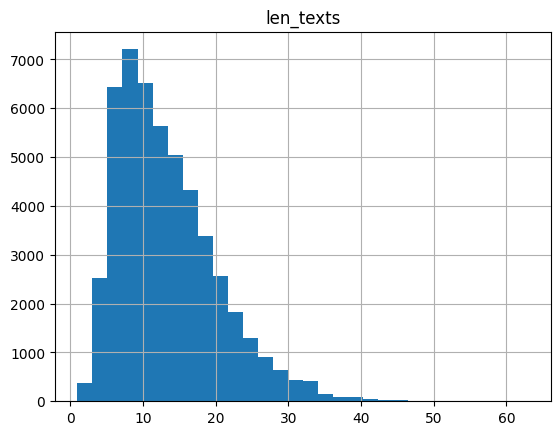

In [33]:
df_len_texts_ru.hist(bins=30);

In [34]:
df_len_texts_en.describe()

,len_texts
count,50000.000000
mean,14.198160
std,6.693823
min,1.000000
25%,9.000000
50%,13.000000
75%,18.000000
max,83.000000


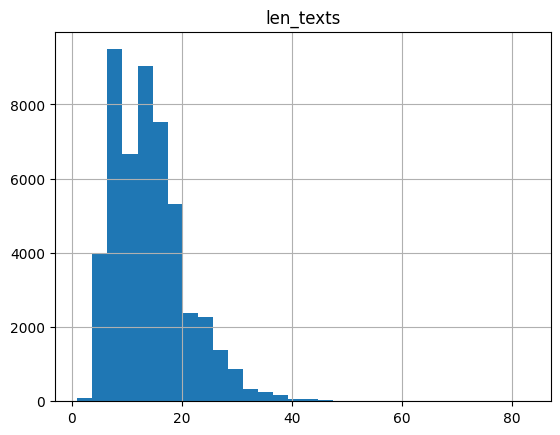

In [35]:
df_len_texts_en.hist(bins=30);

**Вывод**: если посмотреть на распредления длин русских и английских текстов можно заметить, что хорошим параметром максимальной длины в токенизаторе будет в районе 20-30, последовательности больше данной длины будем обрезать

### Подготовка данных 

In [36]:
train_data, test_data = train_test_split(data, test_size=3000, random_state=42)

In [37]:
def create_dict_data(data):
    dict_data = {}
    dict_data['translation'] = []
    
    for d in data:
        dict_data['translation'].append({'ru': d.split('\t')[1][:-1], 'en': d.split('\t')[0]})

    return dict_data

In [38]:
train_data_prep = Dataset.from_dict(create_dict_data(train_data))
test_data_prep = Dataset.from_dict(create_dict_data(test_data))

In [39]:
data_prep = DatasetDict({"train": train_data_prep, "test": test_data_prep})

### Fine-tuning

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en", use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model.to(device)

In [51]:
max_length = 20
batch_size = 32
learning_rate = 2e-5
epochs = 5

In [ ]:
def preprocess_function(examples):
    inputs = [ex["ru"] for ex in examples["translation"]]
    targets = [ex["en"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

tokenized_dataset = data_prep.map(preprocess_function, batched=True)

In [53]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}

    return result

def preprocess_logits_for_metrics(logits, labels):
    """
    Без этого препроцессинга я сутки не мог посчитать метрику из-за CUDA ot of memory...
    Спасибо человеку с обсуждения ниже!!!!
    https://discuss.huggingface.co/t/cuda-out-of-memory-when-using-trainer-with-compute-metrics/2941/12
    """
    pred_ids = torch.argmax(logits[0], dim=-1)
    
    return pred_ids, labels

In [54]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [55]:
training_args = Seq2SeqTrainingArguments(output_dir='/content/drive/MyDrive/tmp/',
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False)

In [56]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics # must have для моего случая
)

In [57]:
train_result = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Bleu,Gen Len
500,2.310200,1.949208,28.717400,19.998000
1000,1.921000,1.753640,30.051800,19.998700
1500,1.762400,1.673494,29.371800,19.998700
2000,1.625700,1.628074,30.072100,19.999300
2500,1.597100,1.593474,30.601500,19.999300
3000,1.564500,1.569674,31.044300,19.999700
3500,1.486600,1.554441,31.126900,19.999700
4000,1.474600,1.539708,31.365700,20.000000
4500,1.448300,1.532679,31.558700,20.000000
5000,1.410900,1.523284,31.687100,20.000000


In [61]:
print(f'Final BLEU seq2seq HF: {trainer.evaluate()["eval_bleu"]}')

# руками пропишу 10 последних значение bleu из логгирования трейнера, нагуглить как у него вытащить именно метрику, а не лосс быстро не получилось
metrics_hf = {}
metrics_hf['dev_bleu'] = [30.601500, 31.044300, 31.126900, 31.365700, 31.558700, 31.687100, 31.588700, 31.877300, 31.954500, 31.913300]

assert np.mean(metrics_hf['dev_bleu'][-10:], axis=0) > 27, "Ты можешь больше! попробуй еще раз)"

Final BLEU seq2seq HF: 31.8692


## Вывод
Финальные метрики BLEU у всех трех подходов:

**seq2seq** - 16.34

**seq2seq with attention** - 23.59

**fine-tuning HF model** - 31.87